# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install torchinfo -qq
else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive


In [3]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023/'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/fmnist'
model_folder.mkdir(parents=True, exist_ok=True)

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms
from data_loaders_fmnist import get_loaders
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, plot_history
from model_two_layer import TwoLayerMLP
from train_functions import train, get_acc_pred
from datetime import datetime

# <Font color = 'indianred'>**Get dataloaders**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
}

In [6]:
train_loader, val_loader, test_loader = get_loaders(data_folder=data_folder ,
                                                    train_transform=data_transforms['train'],
                                                    test_transform=data_transforms['test'],
                                                    fraction_train=0.8,
                                                    seed=42,
                                                    batch_size = 256,
                                                    small_subset= False,
                                                   )

100%|██████████| 26421880/26421880 [00:02<00:00, 10914976.83it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171343.82it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3300946.74it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5132464.22it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [7]:
# check_loader(train_loader)

In [8]:
# check_transforms(train_loader)

In [9]:
# check_label_dist(train_loader)

# <Font color = 'indianred'>**Train Model**

In [10]:
# Define the model architecture and training parameters
num_features = 1*28*28
hidden_dim1 = 200
hidden_dim2 = 100
num_classes = 10
epochs = 10
learning_rate = 0.03


# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

# Define the optimizer for updating model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function for training
loss_function = nn.CrossEntropyLoss()

# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TwoLayerMLP                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 200]                  157,000
│    └─ReLU: 2-3                         [1, 200]                  --
│    └─Linear: 2-4                       [1, 100]                  20,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

In [11]:
# Sanity check to verify initial loss
i = 0
expected_loss = np.log(10)  # Theoretical loss for a random model
for input_, targets in train_loader:
    # Move inputs and targets to the specified device
    input_ = input_.to(device)
    targets = targets.to(device)
    model.to(device)
    model.eval()

    # Forward pass
    output = model(input_)

    # Calculate the loss
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')

    i += 1
    if i > 1:
        break

print(f'Expected Theoretical loss: {expected_loss}')


Actual loss: 2.310985803604126
Actual loss: 2.308560609817505
Expected Theoretical loss: 2.3025850929940455


In [12]:
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, val_loader, model, optimizer, loss_function, epochs, device
)

Epoch 1/10
Train Loss: 1.0497 | Train Accuracy: 67.82%
Valid Loss: 0.6554 | Valid Accuracy: 76.69%

Epoch 2/10
Train Loss: 0.5738 | Train Accuracy: 79.56%
Valid Loss: 0.5498 | Valid Accuracy: 80.23%

Epoch 3/10
Train Loss: 0.5021 | Train Accuracy: 81.99%
Valid Loss: 0.4934 | Valid Accuracy: 82.53%

Epoch 4/10
Train Loss: 0.4623 | Train Accuracy: 83.44%
Valid Loss: 0.4638 | Valid Accuracy: 83.28%

Epoch 5/10
Train Loss: 0.4365 | Train Accuracy: 84.35%
Valid Loss: 0.4420 | Valid Accuracy: 84.56%

Epoch 6/10
Train Loss: 0.4193 | Train Accuracy: 84.94%
Valid Loss: 0.4407 | Valid Accuracy: 84.37%

Epoch 7/10
Train Loss: 0.4022 | Train Accuracy: 85.56%
Valid Loss: 0.4160 | Valid Accuracy: 85.04%

Epoch 8/10
Train Loss: 0.3897 | Train Accuracy: 86.03%
Valid Loss: 0.4036 | Valid Accuracy: 85.64%

Epoch 9/10
Train Loss: 0.3778 | Train Accuracy: 86.35%
Valid Loss: 0.4176 | Valid Accuracy: 85.00%

Epoch 10/10
Train Loss: 0.3684 | Train Accuracy: 86.70%
Valid Loss: 0.4015 | Valid Accuracy: 85.71%


# <Font color = 'indianred'>**Plot Losses**

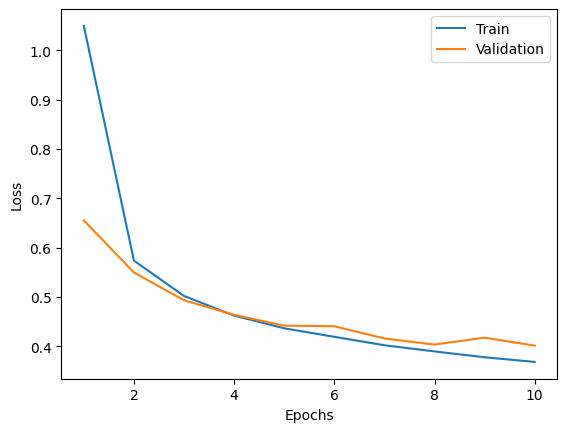

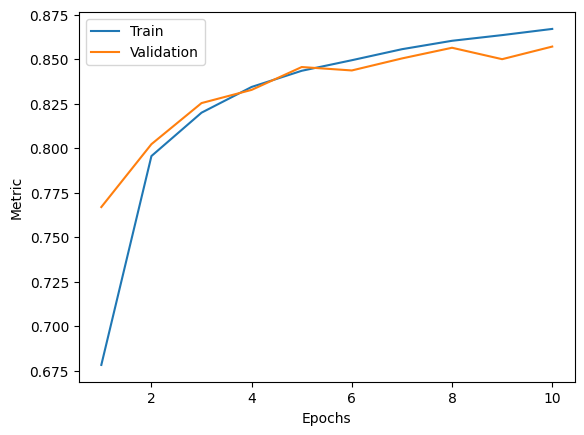

In [13]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# <Font color = 'indianred'>**Checkpointing**

In [14]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/data/models/dl_fall_2023/fmnist/2023-09-25_20-52-47_twolayer.pt')

In [15]:
# Save the model's state dictionary to the specified file path
torch.save(model.state_dict(), path)

# <Font color = 'indianred'>**Get Accuracy, Predictions**

In [16]:
# Create an instance of the model with the same architecture
my_model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [17]:
# Get the prediction and accuracy
# Get the prediction and accuracy
labels_test, predictions_test, acc_test = get_acc_pred(test_loader, my_model, device)
labels_train,predictions_train, acc_train = get_acc_pred(train_loader, my_model, device)
labels_valid, predictions_valid, acc_valid = get_acc_pred(val_loader, my_model, device)

In [18]:
predictions_test[0:5]

tensor([9., 2., 1., 1., 6.], device='cuda:0')

In [19]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(84.3300, device='cuda:0')
Train accuracy tensor(86.3917, device='cuda:0')
Valid accuracy tensor(85.7083, device='cuda:0')


# <Font color = 'indianred'>**Confusion Matrix for Test Data**

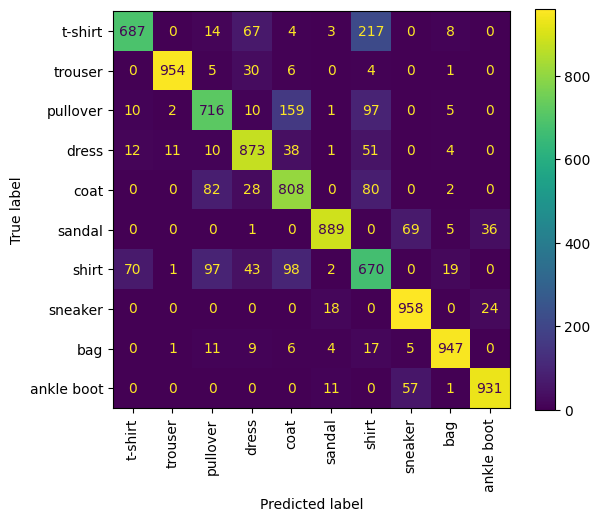

In [20]:
classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

show_confusion_matrix(labels_test, predictions_test, classes)